<a href="https://colab.research.google.com/github/rakesh4real/swift4tensorflow/blob/master/lin_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import TensorFlow

In [2]:
// visualisations
import Python

let plt = Python.import("matplotlib.pyplot")
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


**Create Dataset**

In [0]:
// -------------------------------------------------------
let num_data_points: Float = 100
let num_data_points_int: Int = Int(num_data_points)
let noise_mean = Tensor<Float>(0)
let noise_dev = Tensor<Float>(7)
let w0 = Tensor<Float>(3.0)
let w1 = Tensor<Float>(2.0)
// -------------------------------------------------------

let noise = Tensor<Float>(randomNormal: [num_data_points_int], mean: noise_mean, standardDeviation: noise_dev)

let X = Tensor<Float>(rangeFrom: 0, to: num_data_points, stride: 1) //[0, num_data_points)
let y = w1*X + w0 + noise // y = w1*x + w0 + E 

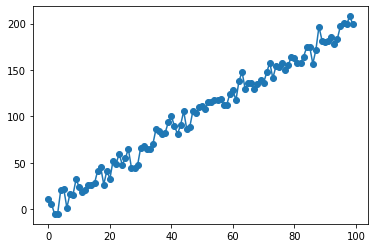

None


In [4]:
// plot
plt.close();
plt.plot(X.makeNumpyArray(), y.makeNumpyArray(), marker: "o")
plt.show();

**Shuffle**

In [0]:
let shuffled_indices = Array<Int>(0..<X.scalarCount).shuffled()

var shuffled_X = Tensor<Float>(zeros: [X.scalarCount]) // temporary
var shuffled_y = Tensor<Float>(zeros: [X.scalarCount]) // temporary

for i in 0..<X.scalarCount {
  shuffled_X[i] = X[shuffled_indices[i]]
  shuffled_y[i] = y[shuffled_indices[i]]
}

**Test - Train Split**

In [0]:
let split_ratio: Float = 0.8
let train_count_after_split = Int( Float(X.scalarCount) * split_ratio )

In [0]:
var train_count = train_count_after_split // Note

In [0]:
// split
var train_x = shuffled_X.slice(lowerBounds: [0], upperBounds: [train_count]) //[0, train_count)
var test_x = shuffled_X.slice(lowerBounds: [train_count], upperBounds: [shuffled_X.scalarCount])
var train_y = shuffled_y.slice(lowerBounds: [0], upperBounds: [train_count])
var test_y = shuffled_y.slice(lowerBounds: [train_count], upperBounds: [shuffled_X.scalarCount])
/*
print(train_x.scalarCount)
print(train_y.scalarCount)
print(test_x.scalarCount)
print(test_y.scalarCount)
*/

**Add Extra Bias (w0)**

In [0]:
// add bias to x_train for mx+'c'
// reshape both(ones & train_x) into col vector before concatenation
var ones_train = Tensor<Float>(ones: [train_count, 1])
var x_train_with_bias = train_x.reshaped(to: [train_count,1]).concatenated(with: ones_train, alongAxis: 1)

var ones_test = Tensor<Float>(ones: [(num_data_points_int - train_count), 1])
var x_test_with_bias = test_x.reshaped(to: [num_data_points_int - train_count, 1]).concatenated(with: ones_test, alongAxis: 1)

In [0]:
// add biases to train_x and test_x
train_x = x_train_with_bias
test_x = x_test_with_bias

// reshape to col vec
train_y = train_y.reshaped(to: [train_count, 1])
test_y = test_y.reshaped(to: [num_data_points_int - train_count, 1])

**Cost Function**

In [0]:
@differentiable
func cost(theta: Tensor<Float>, trues: Tensor<Float>) -> Tensor<Float>{
  var predicted = train_x • theta // Global: train_x
  var data_points = Float(predicted.scalarCount)
  var losses_tensor = (1/2) * pow(predicted - trues, 2) // ------> Tensor
  return ( 1/data_points ) * losses_tensor.sum() // -------> Scalar (Standardized. Minimize it)
}

In [12]:
var theta = Tensor<Float>(randomNormal: [2, 1])
print(theta)

[[0.43261895],
 [ -1.586592]]


In [13]:
print( cost(theta: theta, trues: train_y) )

4473.3555


In [14]:
var grad = gradient(at: theta, train_y, in: cost).0 // Note: '0'
print(grad)

[[-5410.154],
 [-82.29677]]


In [15]:
// Simple

for i in 1...3{
  var grad = gradient(at: theta, train_y, in: cost).0
  theta = theta - grad * 0.001
  print( cost(theta: theta, trues: train_y) )
}


23457.936
123617.02
652037.7


In [16]:
// Little more'
// Note: Doesn't work for 1000 datapoints
var lr = Tensor<Float>(0.0001)
var tolerance = Tensor<Float>(0.001)
var iter = 0 


while true{
  // claculate gradient
  var grad = gradient(at: theta, train_y, in: cost).0  
  var old_theta = theta

  // Correct theta
  theta = theta - grad * lr
  
  // Check tolerance. 
  // pow( pow( , 2), 0.5) is for absolute value
  if Bool( pow( pow(old_theta - theta, 2), 0.5 ).sum().<tolerance )!{
    print("Converged.")
    break
  }

  // every 100th epoch
  if iter % 100 == 0 {
    print("epoch: \(iter)")
    print( cost(theta: theta, trues: train_y) )
  }
  

  iter = iter + 1
}


epoch: 0
292987.78
Converged.


In [17]:
theta

[[2.0748417],
 [-1.555041]]


In [18]:
var preds = train_x • theta
preds  = preds.reshaped(to: [80])
print(preds)

[  199.7046,  137.45935,  4.6694846,  52.390842,   73.13927,  185.18073,   60.69021,     50.316,
  12.968851,  129.15999,   68.98958, 108.411575,  135.38452,  158.20778,   149.9084,   174.8065,
   91.81284,  160.28262,   37.86695,  191.40524,   39.94179,   98.03737,   93.88768, 100.112206,
   77.28895,  -1.555041,  19.193377,  31.642427,  87.663155,  143.68388,   83.51347,  197.62978,
  54.465683,  193.48009,  106.33673,  168.58199,  25.417902,  154.05809,  23.343061,  42.016636,
  44.091476,  166.50714,  122.93546,   81.43863,  133.30968,  46.166317,  102.18705,   66.91474,
   203.8543,    75.2141,  176.88135,   10.89401,  181.03104,  33.717266,  110.48641,   35.79211,
  2.5946426,  151.98325,   6.744326,   139.5342,  183.10588,   62.76505,  21.268219,  145.75873,
  187.25555,  118.78578, 127.085144,  141.60904,   114.6361,  0.5198008,  95.962524,  172.73167,
  112.56126,    64.8399,   8.819167,   189.3304,  162.35745,  201.77945,   85.58832,  56.540527]


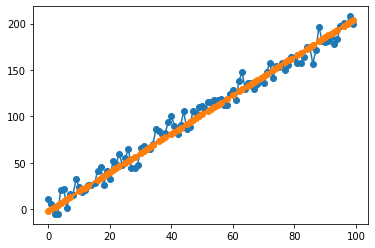

None


In [19]:
plt.close();
plt.plot(X.makeNumpyArray(), y.makeNumpyArray(), marker: "o")
plt.plot(train_x.transposed()[0].reshaped(to: [train_count]).makeNumpyArray(), preds.makeNumpyArray(), marker: "o")
plt.show();